In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('../..')

In [2]:
from lamarck import Optimizer
from lamarck import Population

# Setup

#### Process

In [3]:
def process(x, y):
    val = np.sin(x)*x + np.sin(y)*y
    return {'val': val}

In [4]:
maxrange = 12

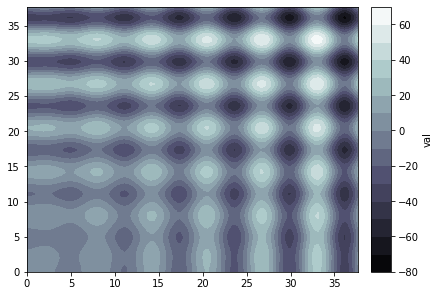

In [5]:
x = np.linspace(0, maxrange*np.pi, 100)
y = np.linspace(0, maxrange*np.pi, 100)
Xi, Yi = np.meshgrid(x, y)
Z = process(Xi, Yi)['val']

fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(x, y, Z, 15, cmap=plt.cm.bone)
cbar = fig.colorbar(CS)
_ = cbar.ax.set_ylabel('val')

# Finding best solutions

In [6]:
opt = Optimizer() 

#### Genome Creation

In [7]:
opt.genome_creator.add_gene_specs.numeric(name='x',
                                          min=0,
                                          max=maxrange*np.pi,
                                          progression='linear',
                                          domain='float')

opt.genome_creator.add_gene_specs.numeric(name='y',
                                          min=0,
                                          max=maxrange*np.pi,
                                          progression='linear',
                                          domain='float')

In [8]:
opt.genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'float',
  'ranges': {'min': 0, 'max': 37.69911184307752, 'progression': 'linear'}},
 'y': {'type': 'numeric',
  'domain': 'float',
  'ranges': {'min': 0, 'max': 37.69911184307752, 'progression': 'linear'}}}

#### Population

In [9]:
opt.create_population(n_det=20, n_rand=600)

<AxesSubplot:xlabel='x', ylabel='y'>

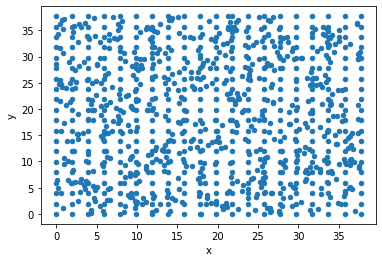

In [10]:
opt.pop.plot.variable_pair('x', 'y')

#### Environment

In [11]:
opt.set_process(process)

### Simulate

In [12]:
optpop = opt.run.single_objective(output='val', objective='max')

100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


In [13]:
optpop.get_creature.best()

[Creature <-4774998632511959481> - genome: {'x': 33.00187099272724, 'y': 32.990054865223016}]

# Evolution of the Species 

In [14]:
gen = 0

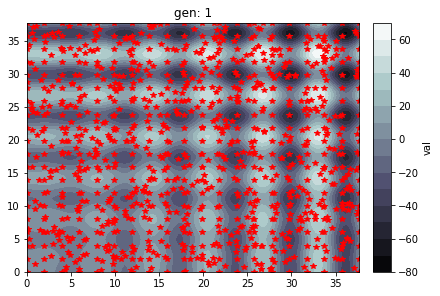

In [15]:
df = optpop.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r*')
ax.set_title(label=f'gen: {gen}')
ax.figure

<AxesSubplot:xlabel='generation', ylabel='val'>

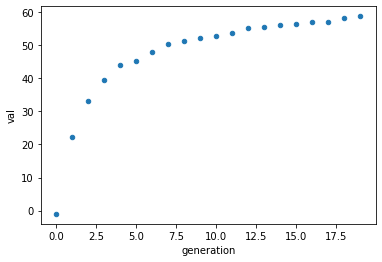

In [16]:
optpop.plot.history('val', 'mean')

# Starting away from optimum

In [17]:
threshold = 10

In [18]:
pop = opt.pop.copy()
popdf = pop.datasets.input
f = (popdf.x < threshold) & (popdf.y < threshold)
popdf = popdf[f].reset_index(drop=True)

In [19]:
new_pop = Population(opt.genome_blueprint)
new_pop.populate.from_genome_dataframe(popdf)
new_pop.define(1000)

In [20]:
opt.set_population(new_pop)

## WITHOUT Mutation

In [21]:
optpop_no_mutation = opt.run.single_objective(output='val', objective='max', p_mutation=0)

100%|██████████| 20/20 [00:00<00:00, 33.61it/s]


In [22]:
gen = 0

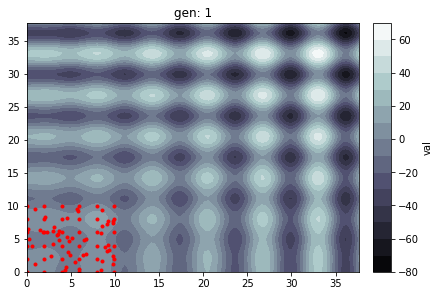

In [23]:
df = optpop_no_mutation.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

### Creatures get stuck

## WITH Mutation

In [24]:
optpop_mutation = opt.run.single_objective(output='val', objective='max', p_mutation=0.05)

100%|██████████| 20/20 [00:00<00:00, 28.35it/s]


In [25]:
gen = 0

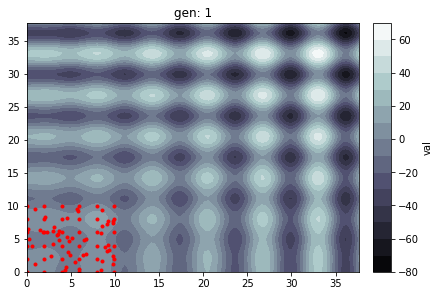

In [26]:
df = optpop_mutation.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

### Now the Creatures gravitate towards the best solutions

## Isolating the best spaces

In [27]:
def new_process(x, y):
    if 10 < x < 30:
        x = 0
    if 10 < y < 30:
        y = 0
    return process(x, y)

def new_process_arr(x, y):
    f = ((x > 10) & (x < 30)) | ((y > 10) & (y < 30))
    x[f] = 36.2
    y[f] = 36.2
    return process(x, y)

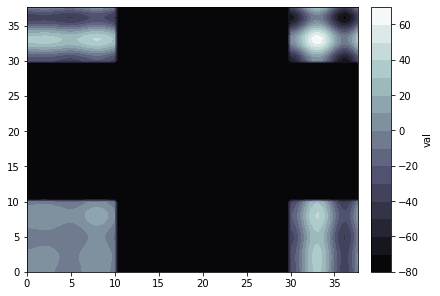

In [28]:
x = np.linspace(0, maxrange*np.pi, 100)
y = np.linspace(0, maxrange*np.pi, 100)
Xi, Yi = np.meshgrid(x, y)
Z = new_process_arr(Xi, Yi)['val']

fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(x, y, Z, 15, cmap=plt.cm.bone)
cbar = fig.colorbar(CS)
_ = cbar.ax.set_ylabel('val')

In [29]:
opt.set_process(new_process)

In [30]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', p_mutation=0.05)

100%|██████████| 20/20 [00:00<00:00, 28.80it/s]


In [31]:
gen = 0

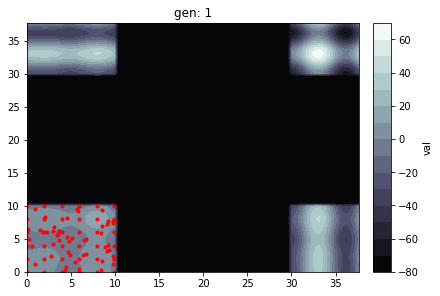

In [32]:
df = optpop_isolated.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

### Creatures still gravitate towards the best solutions, but way slower

<AxesSubplot:xlabel='generation', ylabel='val'>

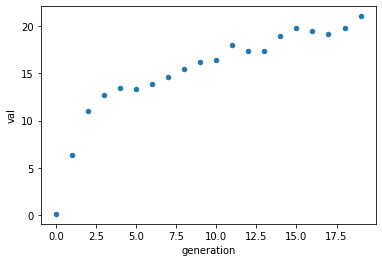

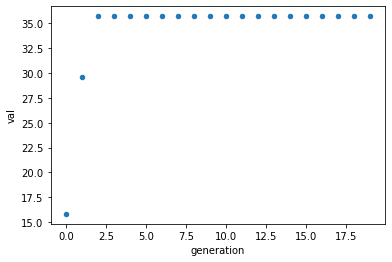

In [33]:
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')

## Let's try more generations

In [34]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', max_generations=200, p_mutation=0.05)

100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


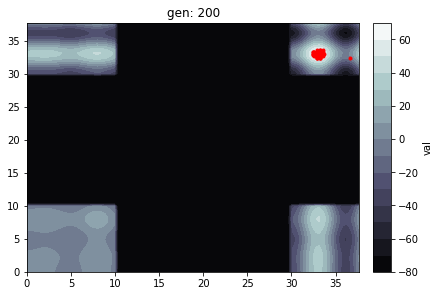

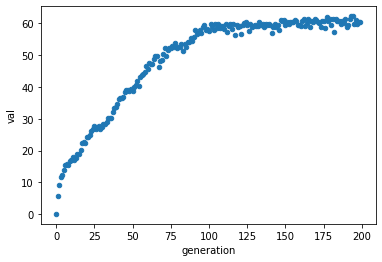

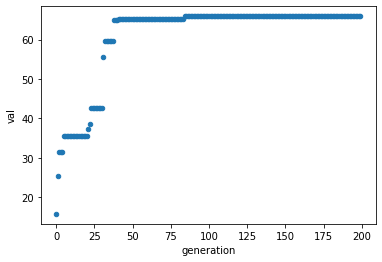

In [35]:
gen = 200

df = optpop_isolated.datasets.get_generation_from_history(gen-1)

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')
ax.figure

## Let's just try a bigger mutation chance

In [36]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', max_generations=20, p_mutation=0.2)

100%|██████████| 20/20 [00:00<00:00, 26.32it/s]


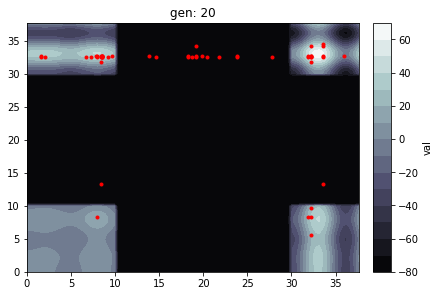

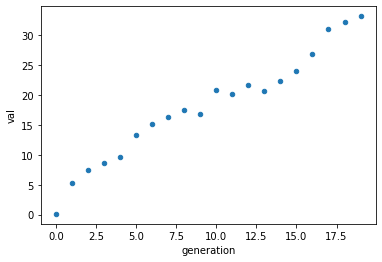

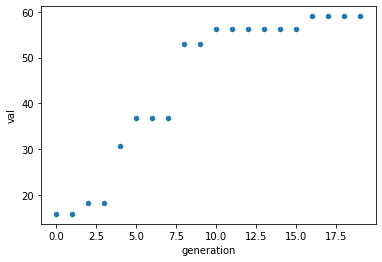

In [37]:
gen = 20

df = optpop_isolated.datasets.get_generation_from_history(gen-1)

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')
ax.figure